In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Javascript, HTML, display
from ipywidgets import Layout

In [4]:
import sys
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
import os, json
from glob import glob
from shapely import wkt
sys.path.append('/home/catskills/Desktop/xview2-catskills/utils')
from display_chips import *

In [5]:
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
def jload(fn):
    with open(fn, 'r') as f:
        return (fn, json.load(f)['features']['xy'])

In [7]:
USERDIR='/home/catskills/Desktop'
DATADIR=f'{USERDIR}/dataxv2'
PROJECT='xview2-catskills'
CODEDIR=f'{USERDIR}/{PROJECT}'
VERSION='v_catskills_0.2.2'
MODEL_DIR=f'/home/catskills/Desktop/dataxv2/release/{VERSION}'
LOCALIZATION_MODEL=f'{MODEL_DIR}/localization.hdf5'
DAMAGE_MODEL=f'{MODEL_DIR}/classification.hdf5'
MEAN_MODEL=f'{CODEDIR}/weights/mean.npy'
VDIR=f'{DATADIR}/train'
TESTDIR=f'{VDIR}/images'
INFER_DIR=f'{VDIR}/labels'
POLYDIR=f'{VDIR}/damage_input'
SUBMIT_DIR=f'{VDIR}/submit'
OUTPUT_CSV=f'{VDIR}/output.csv'
DAMAGE_JSON=f'{VDIR}/damage.json'
COMBINED_JSON=f'{VDIR}/combined_json'
DEBUGDIR=f"{DATADIR}/debug"

In [8]:
infer_jsons=list(sorted(glob(f"{VDIR}/combined_json/*.json")))

In [9]:
gt_jsons=list(sorted(glob(f"{VDIR}/gt_labels/*post*.json")))

In [10]:
pair_fns=list(zip(gt_jsons, infer_jsons))

In [11]:
pairs = [(jload(x),jload(y)) for x,y in pair_fns]

In [12]:
pairs[0][0][0], pairs[0][1][0]

IndexError: list index out of range

In [ ]:
def get_image_fn(fn_gt):
    id=fn_gt.split('/')[-1].split('.')[0].split('_')[-1]
    image_dir='/'.join(fn_gt.split('/')[0:-2]+['images'])
    image_fn=f"{image_dir}/test_pre_{id}.png"
    return image_fn

In [ ]:
for (fn_gt, gt), (fn_pred, pred) in pairs[2:]:
    path_to_image_value=get_image_fn(fn_gt)
    display_chips2(path_to_image_value, pred, gt)
    break

In [49]:
len(gt), len(pred)

(1, 11)

In [ ]:
display_chips2(path_to_image_value, pred, {})

In [ ]:
display_chips2(path_to_image_value, {}, gt)


In [53]:
gtp=[y for x,y in json_to_polygons(gt)]
prp=[y for x,y in json_to_polygons(pred)]
len(gtp), len(prp)

(1, 11)

In [54]:
gtp

In [56]:
grouping=[(gt, [x for x in prp if x.intersects(gt)]) for gt in gtp]
sum([len(y) for x,y in grouping])

7

In [58]:
[len(y) for x,y in grouping]

[7]

In [59]:
[len([x for x in gtp if x.intersects(gt)]) for gt in prp]

[0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]

In [60]:
loc_dist=[(len(gt),len(pred)) for (fn_gt, gt), (fn_pred, pred) in pairs]

In [61]:
loc_dist[0:10]

[(10, 14),
 (4, 4),
 (1, 11),
 (97, 102),
 (9, 6),
 (0, 0),
 (2, 0),
 (13, 30),
 (131, 124),
 (7, 8)]

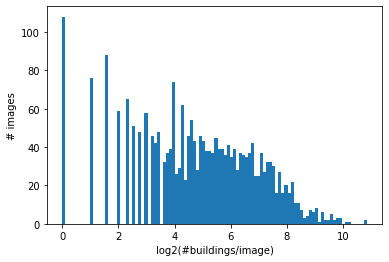

In [80]:
plt.hist([np.log2(gt) for gt,pred in loc_dist if gt], bins=100);
plt.ylabel("# images");
plt.xlabel("log2(#buildings/image)");

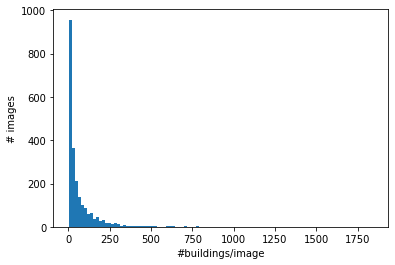

In [82]:
plt.hist([gt for gt,pred in loc_dist if gt], bins=100);
plt.ylabel("# images");
plt.xlabel("#buildings/image");

In [86]:
np.sign(-10)

-1

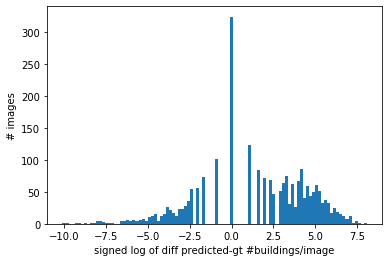

In [89]:
plt.hist([np.sign(pred-gt)*np.log2(np.abs(pred-gt)) for gt,pred in loc_dist if gt!=pred], bins=100);
plt.ylabel("# images");
plt.xlabel("signed log of diff predicted-gt #buildings/image");

In [70]:
len([gt for gt,pred in loc_dist if gt==0])

516

In [71]:
len([pred for gt,pred in loc_dist if gt==0])

516

In [72]:
len(loc_dist)

2799

In [73]:
516/2799

0.18435155412647375

damage class overprediction

In [93]:
pred[0]

{'properties': {'feature_type': 'building',
  'uid': '8546efb9-8707-4af9-bc8e-48580aa50bcf',
  'subtype': 'no-damage'},
 'wkt': 'POLYGON ((981.0 339.0,979.0 341.0,978.0 340.0,977.0 341.0,976.0 341.0,975.0 342.0,973.0 342.0,972.0 343.0,971.0 343.0,970.0 344.0,970.0 345.0,972.0 347.0,975.0 347.0,976.0 348.0,978.0 348.0,979.0 349.0,985.0 349.0,985.0 344.0,984.0 343.0,984.0 342.0,983.0 341.0,983.0 340.0,982.0 339.0,981.0 339.0))'}

In [102]:
damages={'gt':{'destroyed':0, 'major-damage':0, 'minor-damage':0, 'no-damage':0, 'un-classified': 0}, 
         'pred':{'destroyed':0, 'major-damage':0, 'minor-damage':0, 'no-damage':0, 'un-classified': 0}}

In [103]:
for (fn_gt, gt), (fn_pred, pred) in pairs:
    for building in gt:
        damages['gt'][building['properties']['subtype']]+=1
    for building in pred:
        damages['pred'][building['properties']['subtype']]+=1

In [104]:
damages

{'gt': {'destroyed': 13227,
  'major-damage': 14161,
  'minor-damage': 14980,
  'no-damage': 117426,
  'un-classified': 2993},
 'pred': {'destroyed': 21158,
  'major-damage': 4175,
  'minor-damage': 5476,
  'no-damage': 149258,
  'un-classified': 0}}